## IML_Projet_6
Classez des images à l'aide d'algorithmes de Deep Learning

Ce note book contient : 
- La creation et le test de mon propre reseau de neurone CNN 

In [0]:
import os
import pprint
import tensorflow as tf
tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
with tf.Session(tpu_address) as session:
  devices = session.list_devices()
    
print('TPU devices:')
pprint.pprint(devices)

TPU devices:
[_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, 5225350177089248770),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 16328652644730562372),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 6821388559582331547),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 13937315477231802801),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 16224884478558789181),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 13571203328462710476),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 7007633362367077774),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 9020096677664971683),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 12142282294934740653),
 _DeviceAttributes(/job:tpu_w

## Data mount drive folder

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cd /content/drive/My Drive/OpenClassRooms/IML_Projet_6/code/DeepLearningPictureDogs

/content/drive/My Drive/OpenClassRooms/IML_Projet_6/code/DeepLearningPictureDogs


In [0]:
!ls

01_OC_IML_Project_6_explorations.ipynb	       my_utils_dogs.py
02_OC_IML_Project_6_my_neural_network.ipynb    __pycache__
03_OC_IML_Project_6_my_neural_network_2.ipynb  README.md


## Import

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
sns.set(color_codes=True, font_scale=1.33)

import os

import re

import pickle

import time

from sklearn.metrics import accuracy_score
from sklearn.externals import joblib
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import label_binarize

import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 25)

import scipy.io as sio

from PIL import Image
from PIL import ImageOps
from PIL import ImageFilter
import cv2 as cv

import tensorflow
print(tensorflow.__version__)

# keras from scratch
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense
from keras.models import load_model
# keras already trained
from keras.applications.vgg16 import VGG16
# keras image preparation
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
# decode prediction
from keras.applications.vgg16 import decode_predictions
# for training keras model : optimizers
from keras import optimizers
# Keras model base
from keras.models import Model

import json

# ne marche pas (une modif d'une fonction d'un module ne se répercute pas)
# import user module
#from my_utils_dogs import find_breed

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


1.15.0


Using TensorFlow backend.


## Definitions

In [0]:
path_data = '/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/'
path_file_list = 'lists/file_list.mat'
path_test_list = 'lists/test_list.mat'
path_train_list = 'lists/train_list.mat'
path_test_data = 'test_data.mat'
path_train_data = 'train_data.mat'

paths_images_all_breeds = ['Images/n02107683-Bernese_mountain_dog/',
                     'Images/n02088094-Afghan_hound/',
                     'Images/n02096051-Airedale/',
                     'Images/n02090721-Irish_wolfhound/',
                     'Images/n02091831-Saluki/',
                     'Images/n02092002-Scottish_deerhound/',
                     'Images/n02096294-Australian_terrier/',
                     'Images/n02095889-Sealyham_terrier/',
                     'Images/n02095570-Lakeland_terrier/',
                     'Images/n02110185-Siberian_husky/']

nb_breeds = 3
paths_images_breeds = paths_images_all_breeds[:nb_breeds]

path_img_test = path_data + 'Images/n02085620-Chihuahua/' + "n02085620_242.jpg"

path_df_dogs = path_data + 'df_dogs.pkl'
path_X_images = path_data + 'X_images.pkl'
path_Y_images = path_data + 'Y_images.pkl'

name_new_model_2 = 'VGG16_TL_class_01'
path_model_2 = path_data +  name_new_model_2 + '.pkl'

path_df_results = path_data + 'df_results.pkl'

path_imagenet = path_data + 'Images/imagenet_class_index.json'

train_percent = 0.7

## Useful functions

In [0]:
def import_data(paths_images_breeds, train_percent=0.7, force_import=False,
                path_df_dogs=path_df_dogs, path_X_images=path_X_images,
                path_train_list=None):
  '''
  Import data from images on disk

  3 possibilites if force_import = False:
  (1) no data on disk, no data in memory :
    - create df_dogs & X from image files 
    - separate train / test set for df_dogs
  (2) data pickled on disk, no data in memory : 
    - load data from pickled files for df_dogs & X
    - separate train / test set for df_dogs
  (3) data in memory
    - use df_dogs & X from memory 
    - separate train / test set for df_dogs
    - save df_dogs & X on disk
  
  if force_import = True, only  read from image files (1) is possible.

  example: import from memory or already pickled files on disk, with 70% train: 
    df_dogs, X, dict_breed = import_data(paths_images_breeds)
  
  '''
  # import from already processed pickle files on disk
  try:
    if force_import == False:
      df_dogs, X, dict_breed = load_data_breeds() # to load if not exist
      #df_dogs = separate_train_by_class(df_dogs, train_percent=train_percent)
      return df_dogs, X, dict_breed 
  except:
    # if not in memory and not on disk
    pass # continue with importation from images files on disk
  

  # import from image files on disk
  df_dogs = pd.DataFrame(columns=["filename", "path", "breed", "class", 
                                  'Train'])
  # read images in source folders
  X=None
  for id, path_curr in enumerate(paths_images_breeds):
    breed_curr = re.findall('\w+(?=/$)', path_curr)
    print(breed_curr)
    for filename in os.listdir(path_data + path_curr):
      df_add = pd.DataFrame(columns=["filename", "path", "breed", "class", 
                                     "Train"], 
                          index =[0])
      df_add["filename"] = filename
      df_add["path"] = path_data + path_curr + filename
      df_add["breed"] = breed_curr
      df_add["class"] = id
      df_dogs = df_dogs.append(df_add, ignore_index=True)
      # create X image matrix
      img = load_img(df_add["path"].values[0], 
               target_size=(224, 224))  # Charger l'image
      img = img_to_array(img)  # Convertir en tableau numpy
      if X is None:
        X = img[np.newaxis, :]
      X = np.concatenate((X, img[np.newaxis, :]), axis=0)

  # seperate train/test 
  # check test/train mode
  if path_train_list is not None:
    print('Train/Test separation by mat')
    mat_train = sio.loadmat(path_data + path_train_list)
    df_train = pd.DataFrame(data=mat_train["file_list"], 
                           columns=["filename_brut"])
    df_train["filename"] = df_train["filename_brut"].apply(apply_find_filename)
    df_dogs["Train"] = df_dogs["filename"].apply(check_file_train, 
                                                 args=(df_train,))
  else:
    print('Train/Test separation by percent')
    df_dogs = separate_train_by_class(df_dogs, train_percent=train_percent)   
  # preprocess image data for VGG-16
  X = preprocess_input(X)

  # find breed name
  dict_breed = dict()
  for id_class in df_dogs["class"].unique(): 
    dict_breed[id_class] = df_dogs[df_dogs["class"] == \
                                 id_class]["breed"].values[0]
  
  # save on disk
  save_data(df_dogs, path_df_dogs, X, path_X_images)

  return df_dogs, X, dict_breed

def check_file_train(filename, df_train):
  '''
  Apply function for dataFrame column to check Train file from data
  '''
  if filename in df_train["filename"].values:
    return True
  else:
    return False

def apply_find_filename(value):
  '''
  apply function for dataFrame column to extract filename from text

  example : 
    [n02085620-Chihuahua/n02085620_5927.jpg]	-> n02085620_5927.jpg
  '''
  return re.findall('(?<=/).+', value[0])[0]

def load_data_breeds(force_reload=False, path_df_dogs=path_df_dogs,
                     path_X_images=path_X_images):
  '''
  Load data from disk if variable df_dogs & X is not available in memory

  Optional parameter force_reload can be use to force reload in any case.

  example : df_dogs, X, dict_breed = load_data_breeds() # to load if not exist
  '''
  # df_dogs
  if force_reload == False:
    try:
      if df_dogs is not None:
        df_out = df_dogs
      else:
        print("Loading from disk df_dogs...")
        df_out = joblib.load(path_df_dogs)
    except:
      print("Loading from disk df_dogs...")
      df_out = joblib.load(path_df_dogs)
  else:
    print("Loading from disk df_dogs...")
    df_out = joblib.load(path_df_dogs)
  # X images
  if force_reload == False:
    try:
      X_out = X
    except:
      print("Loading from disk X images...")
      X_out = joblib.load(path_X_images)
  else:
    print("Loading from disk X images...")
    X_out = joblib.load(path_X_images)

  # find breed name
  dict_breed = dict()
  for id_class in df_out["class"].unique(): 
    dict_breed[id_class] = df_out[df_out["class"] == \
                                 id_class]["breed"].values[0]
  
  return df_out, X_out, dict_breed

def separate_train_by_class(df_dogs, train_percent=0.7):

  '''
  Separate TRAIN / TEST set per breed

  by default train_percent = 0.7

  add "Train" column to df_dogs

  example : df_dogs = separate_train_by_class(df_dogs, train_percent=0.7)
  '''

  df_dogs['Train'] = False
  for id_class in df_dogs["class"].unique():
    np.random.seed(0)
    indices_permut = np.random.permutation(\
      df_dogs[df_dogs["class"] == id_class].shape[0])
    indices_permut_train = \
      indices_permut[0:np.int(len(indices_permut)*train_percent)]
    index_train  = df_dogs[df_dogs["class"] == \
                         id_class].iloc[indices_permut_train].index
    df_dogs.loc[index_train, "Train"] = True

  v= df_dogs["Train"].value_counts()
  print("% of Train : {:.2f} %".format(100*v.loc[True]/sum(v)))
  print(df_dogs["Train"].value_counts())

  return df_dogs

def create_separate_features(df_dogs, X, list_X_classes=None,
                             list_Y_classes=None):
  '''
  Seperate train/test matrix of images to be use by CNN Models
  
  example : 
    X_train, X_test, Y_train, Y_test, lb = create_separate_features(df_dogs, X)
  '''
  # select from df_dogs & X only list of breed : list_X_classes
  def fun_class_ok(classNum):
    if classNum in list_X_classes:
      return True
    else:
      return False
  
  if list_X_classes is not None:
    df_in = df_dogs
    df_in["class_OK"] = False
    df_in["class_OK"] = df_dogs["class"].apply(fun_class_ok)

    df_in = df_in[df_in["class_OK"] == True]
  else:
    df_in = df_dogs
  
  # seperate train/test matrix of images 
  index_train = df_in[df_in["Train"] == True].index
  index_test = df_in[df_in["Train"] == False].index
  X_train = X[index_train,:,:,:]
  X_test = X[index_test,:,:,:]

  # prepare for Y the classes
  if list_Y_classes is None:
    lb = LabelBinarizer()
    lb.fit(df_in["class"].tolist())
    Y_train = lb.transform(df_in[df_in["Train"] == True]["class"].tolist())
    Y_test =  lb.transform(df_in[df_in["Train"] == False]["class"].tolist())
  else:
    # use list_Y_classes
    # lb function
    def lb(x):
      return label_binarize(x, classes=list_Y_classes)
    # transform train set
    Y_train = lb(
        df_in[df_in["Train"] == True]["breed"].tolist())
    # transform test set
    Y_test = lb(
        df_in[df_in["Train"] == False]["breed"].tolist())

  return X_train, X_test, Y_train, Y_test, lb

def load_prepare_img(path_img):
  '''
  Load image from path and prepare for VGG-16
  return : 
    img : np array
    img_raw : Image from PIL

  example : img, img_raw = load_prepare_img(path_img)
  '''

  img_raw = load_img(path_img, target_size=(224, 224))  # Charger l'image
  img = img_to_array(img_raw)  # Convertir en tableau numpy
  img = img[np.newaxis, :]
  img = preprocess_input(img)  # Prétraiter l'image comme le veut VGG-16
  img_raw
  return img, img_raw

def get_imagenet_classes():
  # get labels
  with open(path_imagenet) as json_data:
    class_idx = json.load(json_data)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
    # PATCH : to correct double classes
    idx2label[idx2label.index("crane")] = "crane_0"
    idx2label[idx2label.index("maillot")] = "maillot_0"
  return idx2label

In [0]:
def save_data(df_dogs, path_df_dogs, X, path_X_images):
  '''
  Save data on disk : df_dogs & X images

  example : save_data(df_dogs, path_df_dogs, X, path_X_images)

  '''
  joblib.dump(df_dogs, path_df_dogs, compress=True)
  print("df_dogs Saved here:\n{}".format(path_df_dogs))
  joblib.dump(X, path_X_images, compress=True)
  print("X Saved here:\n{}".format(path_X_images))

In [0]:
def predict_breed_from_one_path(path_img, mdl):
  '''
  Predict Breed Name from one image path

  example : breedName = predict_breed_from_one_path(path_img, model)
  '''
  print(path_img)
  img, img_raw = load_prepare_img(path_img)
  y = mdl.predict(img) 
  if y.shape[1] >= 1000:
    breedName = decode_predictions(y, top=3)[0]
    print('VGG-16 : Top 3 :', breedName)
  else:
    print("Probabilities : ", y)
    breedName = find_breed(y, dict_breed)
  print(breedName)
  return breedName, img_raw

  def find_breed(y, dict_breed):
    '''
    Find Breed Name from y output of CNN model
    breed_name = find_breed(y, dict_breed)
    '''
    return dict_breed[np.argmax(y)]

In [0]:
def evaluate_mdl_scorings(Y_train, Y_train_pred,
                          Y_test, Y_test_pred, 
                          timing_fit=0, timing_pred=0):

    '''
    Take scores from predictions
    V1.1 : 24/11/2019 : add acc test per breed
    '''
    dict_scores = dict()
    
    #calculate over same splits f1_micro mean & std
    #cv_lda

    '''
    f1_splits = []
    # on splits test
    for train_index, test_index in cv_lda.split(enc_lda_y_train):
        f1_splits.append(f1_score(enc_lda_y_train[test_index], 
                                  enc_lda_ypred_train[test_index], 
                                  average='micro'))  
    dict_scores["f1_splits_test"] = np.mean(f1_splits)
    dict_scores["f1_splits_test_std"] = np.std(f1_splits)
    '''
    
    # transform as class number 
    Y_train_pred_num = np.argmax(Y_train_pred, axis=1)
    Y_train_num = np.argmax(Y_train, axis=1)
    Y_test_pred_num = np.argmax(Y_test_pred, axis=1)
    Y_test_num = np.argmax(Y_test, axis=1)

    dict_scores["acc_train"] = accuracy_score(Y_train_num, Y_train_pred_num)

    dict_scores["acc_test"] = accuracy_score(Y_test_num, Y_test_pred_num)

    dict_scores["t_fit"] = timing_fit
    dict_scores["t_pred"] = timing_pred

    # find sort of breed name in Y classes (imagent) vs. X classes 
    # (selection of dogs)
    list_id=[]
    for id_y in np.unique(Y_test_num):
      for num_breed, breed_name in dict_breed.items():
        if breed_name == list_Y_classes[id_y]:
          list_id.append(num_breed)
    # add accuracy per breed
    K_id=0
    for id_class in np.unique(Y_test_num):
      str_dict_entry = "acc_test_{}B_{}".format(len(np.unique(Y_test_num)), list_id[K_id])
      dict_scores[str_dict_entry] = accuracy_score(
          Y_test_num[Y_test_num == id_class], 
          Y_test_pred_num[Y_test_num == id_class])
      K_id += 1
    
    return pd.Series(data = dict_scores)

def add_score(df_results, series_scores, model_name):
    
    df_results_add = pd.DataFrame(data=series_scores, columns=[model_name]).T
    
    if df_results is None: # create table
        print('create df_results')
        df_results = df_results_add.copy()
    else: # update or add line
        try:
            # ligne existe alors on efface l'ancienne ligne  ?
            df_results = df_results.drop(index=model_name)                                
            print('update line')
        except:
            # n'existe pas
            print('add line')
            
        # on ajoute la ligne
        df_results = df_results.append(df_results_add)
        
    return df_results

#### plot_history

In [0]:
def plot_history(history, my_title=None):
  # plot results at each iterations
  fig = plt.figure(figsize=(12, 8))
  if my_title is not None:
    fig.suptitle(my_title, fontsize=18)
  ax1 = fig.add_subplot(2,2,1)
  ax1.plot(range(0, len(history["acc"])), 
          history["acc"], 'o-')
  ax1.set_xlabel("epochs [-]")
  ax1.set_ylabel("accuracy [-]")
  ax2 = fig.add_subplot(2,2,2)
  ax2.set_xlabel("epochs [-]")
  ax2.set_ylabel("acc test [-]")
  ax2.plot(range(0, len(history['val_acc'])), 
          history["val_acc"], 'ro-')
  ax3 = fig.add_subplot(2,2,3)
  ax3.set_xlabel("epochs [-]")
  ax3.set_ylabel("loss [-]")
  ax3.plot(range(0, len(history['loss'])), 
          history["loss"], 'o-')

  ax4 = fig.add_subplot(2,2,4)
  ax4.set_xlabel("epochs [-]")
  ax4.set_ylabel("val_loss [-]")
  ax4.plot(range(0, len(history['val_loss'])), 
          history["val_loss"], 'ro-')

### plot_confusion_matrix

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues, size=16, fontsize=12, 
                          threshold=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    source : 
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]

    # extract most important confusion if threshold
    if threshold is not None:
      list_idx=[]
      for i in range(0, cm.shape[0]):
        for j in range(0, cm.shape[1]):
          if i != j:
            if cm[i,j] > threshold:
              list_idx.append(i)
              list_idx.append(j)
      list_idx = np.unique(list_idx)
      cm = cm[np.ix_(list_idx, list_idx)]
      classes = classes[list_idx]

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
 
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor", fontsize=fontsize)
    # resize y tick labels
    plt.setp(ax.get_yticklabels(), fontsize=fontsize)
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black",
                    fontsize=fontsize,
                    fontweight="black" if i==j else "normal")
    fig.tight_layout()

    fig.set_size_inches([size,size])
    ax.set_ylim([cm.shape[1]-0.5,-0.5]);
    ax.grid(linewidth=0)
    return ax

## Data importation

### Load images of dogs from different folders

In [0]:
force_import = False # only from disk or memory
df_dogs = None # from disk

In [0]:
# import data from disk images & save them into memory and DISK !
df_dogs, X, dict_breed = import_data(paths_images_all_breeds, 
                                     force_import=force_import, 
                                     path_train_list=path_train_list)
# check
print("Image matrix size : ", X.shape)
df_dogs.head()

Loading from disk df_dogs...
Loading from disk X images...
Image matrix size :  (2097, 224, 224, 3)


,filename,path,breed,class,Train
0,n02107683_1175.jpg,/content/drive/My Drive/OpenClassRooms/IML_Pro...,Bernese_mountain_dog,0,False
1,n02107683_1248.jpg,/content/drive/My Drive/OpenClassRooms/IML_Pro...,Bernese_mountain_dog,0,True
2,n02107683_1244.jpg,/content/drive/My Drive/OpenClassRooms/IML_Pro...,Bernese_mountain_dog,0,True
3,n02107683_1003.jpg,/content/drive/My Drive/OpenClassRooms/IML_Pro...,Bernese_mountain_dog,0,False
4,n02107683_1076.jpg,/content/drive/My Drive/OpenClassRooms/IML_Pro...,Bernese_mountain_dog,0,False


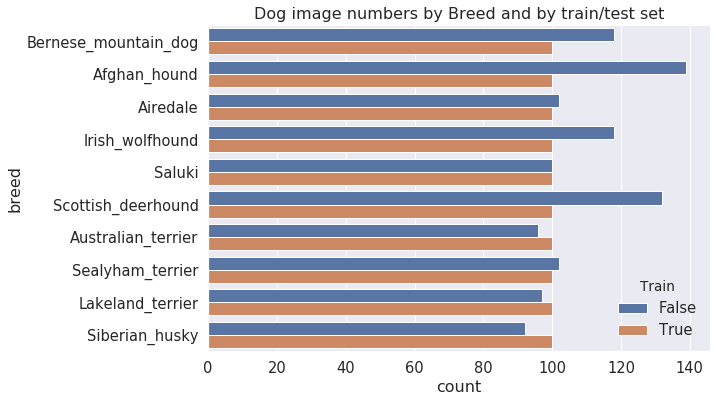

In [0]:
# Categorical bar plot with train/test
fig = plt.figure(figsize=(9, 6))
plt.title("Dog image numbers by Breed and by train/test set")
ax = sns.countplot(y="breed", hue="Train", data=df_dogs)

## Keras Neural Network from scratch

Just the first part : Neural Network Structure before fitting process

### Features

In [0]:
nb_breeds

3

In [0]:
X_train, X_test, Y_train, Y_test, lb = create_separate_features(df_dogs,
  X, list_X_classes=np.array(range(nb_breeds)))
print("X_train ",X_train.shape)
print("X_test ",X_test.shape)
print("Y_train ",Y_train.shape)
print("Y_test ",Y_test.shape)

list_Y_classes = list(dict_breed.values())[:nb_breeds]
list_Y_classes

X_train  (300, 224, 224, 3)
X_test  (359, 224, 224, 3)
Y_train  (300, 3)
Y_test  (359, 3)


['Bernese_mountain_dog', 'Afghan_hound', 'Airedale']

### Loop over nb conv filters / 50 nodes FC / init Glorot uniform fixed seed (3 runs)

Output layer is fixed to 50.


##### Test one shot

Model: "my_VGG16_03_gu_early"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 200704)            0         
_________________________________________________________________
dense_9 (Dense)              (None, 50)                10035250  
_________________________________________________________________
dense_10 (Dense)             (None, 3)        

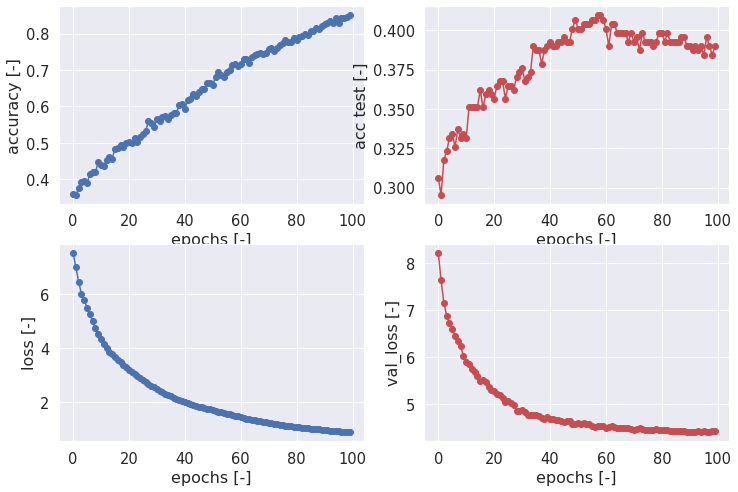

In [0]:
# initializers 
init_he_n = keras.initializers.he_normal(seed=0)
init_glorot_u = keras.initializers.glorot_uniform(seed=0)
# Hyper-parameters
lr = 3e-8
decay = 1e-6
momentum = 0.9
nesterov = True 
nb_filters = 64 # Conv2D layers
nb_nodes = 50 # first FC layer
conv_init = init_glorot_u # Conv2D layers
dens_init = init_glorot_u # first FC layer
out_init = init_glorot_u # output FC layer
# Fitting parameters
epochs = 100
batch_size = None
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                   verbose=1, patience=10,
                                   restore_best_weights=True)
# Model creation
my_VGG16_03 = Sequential()  # Création d'un réseau de neurones vide 
my_VGG16_03.name = 'my_VGG16_03_gu_early'
# Ajout de la première couche de convolution, suivie d'une couche ReLU
my_VGG16_03.add(Conv2D(nb_filters, kernel_size=3, strides=1, 
                       input_shape=(224, 224, 3),
                       padding='same', activation='relu',
                       kernel_initializer=conv_init))
my_VGG16_03.add(MaxPooling2D(pool_size=(2,2), strides=(2,2))) # test
# Ajout de la deuxième couche de convolution, suivie  d'une couche ReLU
my_VGG16_03.add(Conv2D(nb_filters, kernel_size=3, strides=1, padding='same', 
                       activation='relu',
                       kernel_initializer=conv_init))

# Ajout de la première couche de pooling
my_VGG16_03.add(MaxPooling2D(pool_size=(2,2), strides=(2,2))) # test
my_VGG16_03.add(Flatten())  # Conversion des matrices 3D en vecteur 1D

# Ajout de la première couche fully-connected, suivie d'une couche ReLU
my_VGG16_03.add(Dense(nb_nodes, activation='relu',
                  kernel_initializer=dens_init))

# Ajout de la dernière couche fully-connected qui permet de classifier
my_VGG16_03.add(Dense(nb_breeds, activation='softmax',
                kernel_initializer=out_init))
print(my_VGG16_03.summary())

# optimizer
sgd_2 = optimizers.SGD(lr=lr, decay=decay, momentum=momentum, nesterov=nesterov) 
# compile model
my_VGG16_03.compile(loss="categorical_crossentropy", optimizer=sgd_2, 
                 metrics=["accuracy"])

# fitting
t_fit_0 = time.time()
model_info_3 = my_VGG16_03.fit(X_train, Y_train, epochs=epochs, 
                             batch_size=batch_size, verbose=2,
                             validation_data=(X_test, Y_test),
                             callbacks=[es])
t_fit_1 = time.time()
print("Timing: ", t_fit_1 - t_fit_0)

# plot results at each iterations
plot_history(model_info_3.history)

In [0]:
name_df_res = 'df_res_filters_gu0_50nod'
print(name_df_res + " Saved here:\n" + path_data + name_df_res + '.pkl')

df_res_filters_gu0_50nod Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_res_filters_gu0_50nod.pkl


##### Loop over filters 64 128 256

nb_filters:  64
nb_try:  0
Model: "my_VGG16_03_64filt_gu0_50nod_0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 200704)            0         
_________________________________________________________________
dense_11 (Dense)             (None, 50)                10035250  
_________________________________________________________________
dense_12 

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/150
 - 2s - loss: 7.5578 - acc: 0.3600 - val_loss: 8.2482 - val_acc: 0.3036
Epoch 2/150
 - 2s - loss: 7.0857 - acc: 0.3533 - val_loss: 7.6459 - val_acc: 0.2981
Epoch 3/150
 - 2s - loss: 6.5145 - acc: 0.3567 - val_loss: 7.1910 - val_acc: 0.3036
Epoch 4/150
 - 2s - loss: 6.0728 - acc: 0.3867 - val_loss: 6.9199 - val_acc: 0.3287
Epoch 5/150
 - 2s - loss: 5.7775 - acc: 0.4033 - val_loss: 6.7549 - val_acc: 0.3315
Epoch 6/150
 - 2s - loss: 5.5150 - acc: 0.4033 - val_loss: 6.7082 - val_acc: 0.3398
Epoch 7/150
 - 2s - loss: 5.2662 - acc: 0.4167 - val_loss: 6.6273 - val_acc: 0.3370
Epoch 8/150
 - 2s - loss: 5.0674 - acc: 0.4300 - val_loss: 6.5696 - val_acc: 0.3370
Epoch 9/150
 - 2s - loss: 4.8561 - acc: 0.4300 - val_loss: 6.3140 - val_acc: 0.3343
Epoch 10/150
 - 2s - loss: 4.6490 - acc: 0.4300 - val_loss: 6.1443 - val_acc: 0.3398
Epoch 11/150
 - 2s - loss: 4.4438 - acc: 0.4367 - val_loss: 6.0246 - val_acc: 0.3510
Epoch 12/150
 - 2s - loss: 4

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/150
 - 7s - loss: 6.7090 - acc: 0.3367 - val_loss: 6.6327 - val_acc: 0.3343
Epoch 2/150
 - 4s - loss: 5.9640 - acc: 0.3667 - val_loss: 6.1389 - val_acc: 0.3259
Epoch 3/150
 - 4s - loss: 5.3080 - acc: 0.3467 - val_loss: 5.9625 - val_acc: 0.3398
Epoch 4/150
 - 4s - loss: 4.9657 - acc: 0.3833 - val_loss: 5.8307 - val_acc: 0.3510
Epoch 5/150
 - 4s - loss: 4.7021 - acc: 0.3900 - val_loss: 5.7539 - val_acc: 0.3538
Epoch 6/150
 - 4s - loss: 4.4900 - acc: 0.4100 - val_loss: 5.6893 - val_acc: 0.3565
Epoch 7/150
 - 4s - loss: 4.2782 - acc: 0.4100 - val_loss: 5.6351 - val_acc: 0.3538
Epoch 8/150
 - 4s - loss: 4.0874 - acc: 0.4300 - val_loss: 5.5520 - val_acc: 0.3649
Epoch 9/150
 - 4s - loss: 3.9417 - acc: 0.4400 - val_loss: 5.4848 - val_acc: 0.3705
Epoch 10/150
 - 4s - loss: 3.7410 - acc: 0.4600 - val_loss: 5.4427 - val_acc: 0.3649
Epoch 11/150
 - 4s - loss: 3.5941 - acc: 0.4567 - val_loss: 5.3867 - val_acc: 0.3705
Epoch 12/150
 - 4s - loss: 3

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/150
 - 5s - loss: 6.6818 - acc: 0.3333 - val_loss: 6.5963 - val_acc: 0.3259
Epoch 2/150
 - 4s - loss: 5.7453 - acc: 0.3733 - val_loss: 6.1257 - val_acc: 0.3259
Epoch 3/150
 - 4s - loss: 5.4547 - acc: 0.3700 - val_loss: 6.0349 - val_acc: 0.3426
Epoch 4/150
 - 4s - loss: 5.0253 - acc: 0.3900 - val_loss: 5.8102 - val_acc: 0.3343
Epoch 5/150
 - 4s - loss: 4.7241 - acc: 0.3900 - val_loss: 5.7414 - val_acc: 0.3593
Epoch 6/150
 - 4s - loss: 4.4707 - acc: 0.3900 - val_loss: 5.6502 - val_acc: 0.3510
Epoch 7/150
 - 4s - loss: 4.2699 - acc: 0.4200 - val_loss: 5.6115 - val_acc: 0.3538
Epoch 8/150
 - 4s - loss: 4.1002 - acc: 0.4267 - val_loss: 5.5544 - val_acc: 0.3593
Epoch 9/150
 - 4s - loss: 3.9506 - acc: 0.4333 - val_loss: 5.5061 - val_acc: 0.3593
Epoch 10/150
 - 4s - loss: 3.7839 - acc: 0.4700 - val_loss: 5.4584 - val_acc: 0.3677
Epoch 11/150
 - 4s - loss: 3.5936 - acc: 0.4733 - val_loss: 5.3845 - val_acc: 0.3760
Epoch 12/150
 - 4s - loss: 3

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/150
 - 5s - loss: 6.6782 - acc: 0.3267 - val_loss: 6.5546 - val_acc: 0.3203
Epoch 2/150
 - 4s - loss: 5.7448 - acc: 0.3733 - val_loss: 6.2237 - val_acc: 0.3120
Epoch 3/150
 - 4s - loss: 5.3561 - acc: 0.3867 - val_loss: 6.0245 - val_acc: 0.3343
Epoch 4/150
 - 4s - loss: 4.9735 - acc: 0.3833 - val_loss: 5.8001 - val_acc: 0.3426
Epoch 5/150
 - 4s - loss: 4.7434 - acc: 0.3867 - val_loss: 5.7334 - val_acc: 0.3398
Epoch 6/150
 - 4s - loss: 4.4770 - acc: 0.4067 - val_loss: 5.7159 - val_acc: 0.3538
Epoch 7/150
 - 4s - loss: 4.3010 - acc: 0.4200 - val_loss: 5.6368 - val_acc: 0.3565
Epoch 8/150
 - 4s - loss: 4.1368 - acc: 0.4333 - val_loss: 5.5679 - val_acc: 0.3677
Epoch 9/150
 - 4s - loss: 3.9317 - acc: 0.4467 - val_loss: 5.5254 - val_acc: 0.3788
Epoch 10/150
 - 4s - loss: 3.7560 - acc: 0.4533 - val_loss: 5.4723 - val_acc: 0.3733
Epoch 11/150
 - 4s - loss: 3.6252 - acc: 0.4667 - val_loss: 5.4121 - val_acc: 0.3760
Epoch 12/150
 - 4s - loss: 3

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/150
 - 15s - loss: 4.6558 - acc: 0.3833 - val_loss: 4.8596 - val_acc: 0.3287
Epoch 2/150
 - 8s - loss: 4.1095 - acc: 0.3900 - val_loss: 4.7410 - val_acc: 0.3343
Epoch 3/150
 - 8s - loss: 3.7038 - acc: 0.4200 - val_loss: 4.6142 - val_acc: 0.3287
Epoch 4/150
 - 8s - loss: 3.4078 - acc: 0.4267 - val_loss: 4.5196 - val_acc: 0.3398
Epoch 5/150
 - 8s - loss: 3.0960 - acc: 0.4400 - val_loss: 4.3068 - val_acc: 0.3482
Epoch 6/150
 - 8s - loss: 2.8214 - acc: 0.4633 - val_loss: 4.1810 - val_acc: 0.3510
Epoch 7/150
 - 8s - loss: 2.6045 - acc: 0.5000 - val_loss: 4.0996 - val_acc: 0.3760
Epoch 8/150
 - 8s - loss: 2.4293 - acc: 0.5100 - val_loss: 4.0347 - val_acc: 0.3844
Epoch 9/150
 - 8s - loss: 2.2593 - acc: 0.5200 - val_loss: 3.9445 - val_acc: 0.3788
Epoch 10/150
 - 8s - loss: 2.0877 - acc: 0.5433 - val_loss: 3.8547 - val_acc: 0.3788
Epoch 11/150
 - 8s - loss: 1.9634 - acc: 0.5667 - val_loss: 3.8065 - val_acc: 0.3928
Epoch 12/150
 - 8s - loss: 

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/150
 - 9s - loss: 4.7345 - acc: 0.3733 - val_loss: 4.8633 - val_acc: 0.3343
Epoch 2/150
 - 8s - loss: 3.9893 - acc: 0.4033 - val_loss: 4.6989 - val_acc: 0.3259
Epoch 3/150
 - 8s - loss: 3.6583 - acc: 0.4100 - val_loss: 4.6020 - val_acc: 0.3315
Epoch 4/150
 - 8s - loss: 3.3671 - acc: 0.4233 - val_loss: 4.4642 - val_acc: 0.3370
Epoch 5/150
 - 8s - loss: 3.1155 - acc: 0.4367 - val_loss: 4.2882 - val_acc: 0.3482
Epoch 6/150
 - 8s - loss: 2.8448 - acc: 0.4533 - val_loss: 4.2062 - val_acc: 0.3621
Epoch 7/150
 - 8s - loss: 2.5849 - acc: 0.4900 - val_loss: 4.1294 - val_acc: 0.3565
Epoch 8/150
 - 8s - loss: 2.4212 - acc: 0.4933 - val_loss: 4.0106 - val_acc: 0.3705
Epoch 9/150
 - 8s - loss: 2.2375 - acc: 0.5233 - val_loss: 3.9260 - val_acc: 0.3816
Epoch 10/150
 - 8s - loss: 2.0743 - acc: 0.5467 - val_loss: 3.8639 - val_acc: 0.3844
Epoch 11/150
 - 8s - loss: 1.9267 - acc: 0.5700 - val_loss: 3.7730 - val_acc: 0.3788
Epoch 12/150
 - 8s - loss: 1

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,



Total params: 40,738,251
Trainable params: 40,738,251
Non-trainable params: 0
_________________________________________________________________
None
Train on 300 samples, validate on 359 samples
Epoch 1/150
 - 10s - loss: 4.8035 - acc: 0.3800 - val_loss: 4.8607 - val_acc: 0.3343
Epoch 2/150
 - 8s - loss: 4.0347 - acc: 0.3867 - val_loss: 4.6796 - val_acc: 0.3231
Epoch 3/150
 - 8s - loss: 3.7537 - acc: 0.4133 - val_loss: 4.5636 - val_acc: 0.3259
Epoch 4/150
 - 8s - loss: 3.3488 - acc: 0.4300 - val_loss: 4.4429 - val_acc: 0.3426
Epoch 5/150
 - 8s - loss: 3.1065 - acc: 0.4300 - val_loss: 4.2711 - val_acc: 0.3538
Epoch 6/150
 - 8s - loss: 2.9110 - acc: 0.4667 - val_loss: 4.1965 - val_acc: 0.3593
Epoch 7/150
 - 8s - loss: 2.6279 - acc: 0.4833 - val_loss: 4.1131 - val_acc: 0.3733
Epoch 8/150
 - 8s - loss: 2.4406 - acc: 0.5033 - val_loss: 4.0131 - val_acc: 0.3649
Epoch 9/150
 - 8s - loss: 2.2427 - acc: 0.5167 - val_loss: 3.9102 - val_acc: 0.3788
Epoch 10/150
 - 8s - loss: 2.1013 - acc: 0.5300

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/150


ResourceExhaustedError: ignored

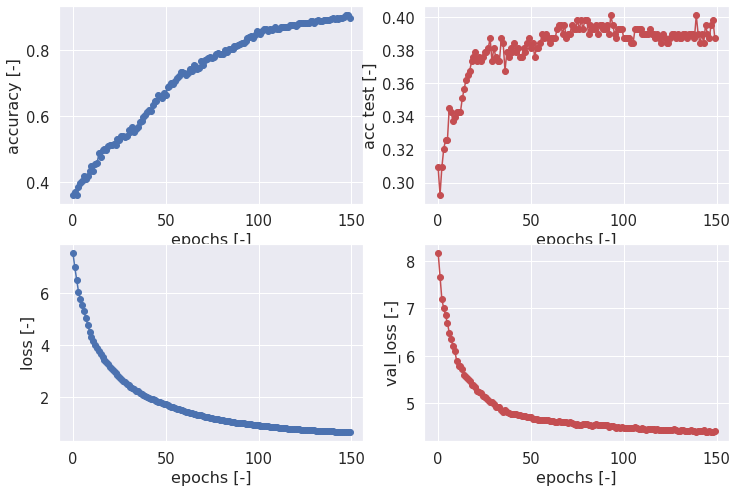

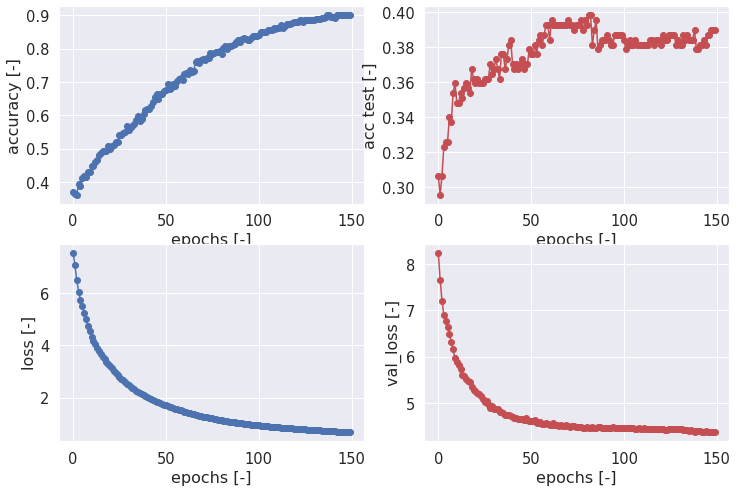

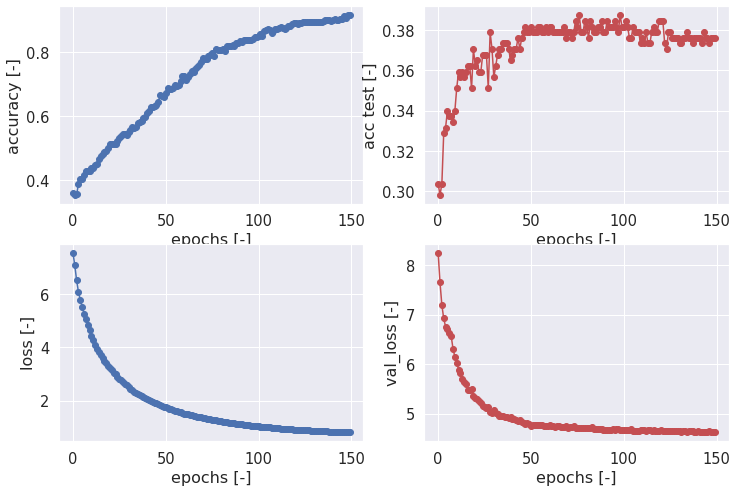

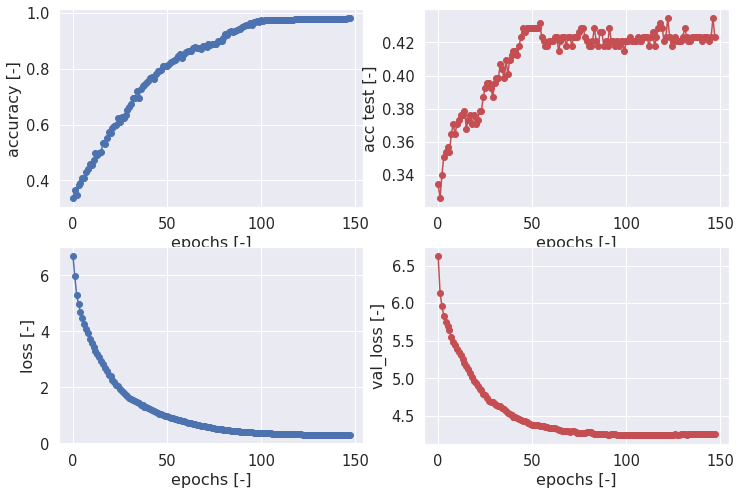

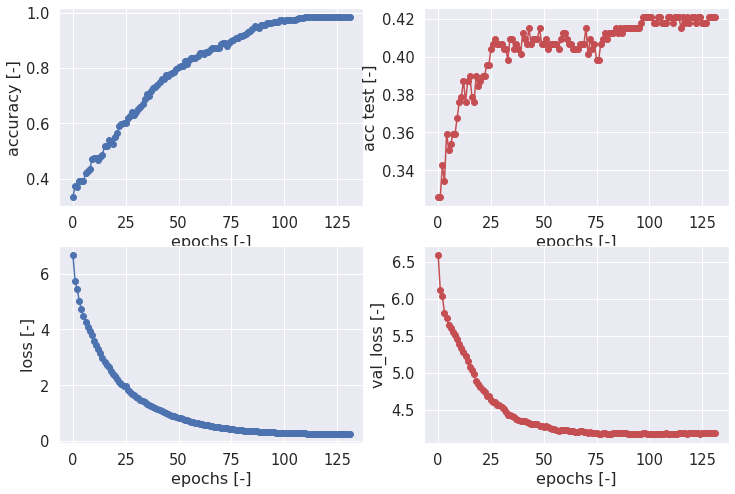

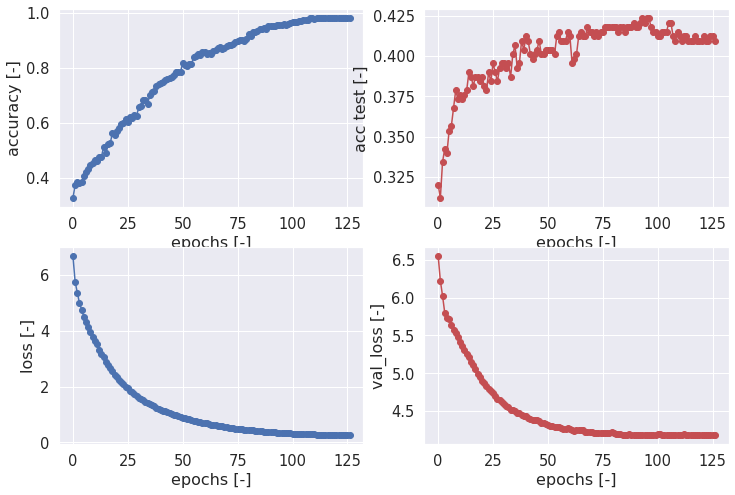

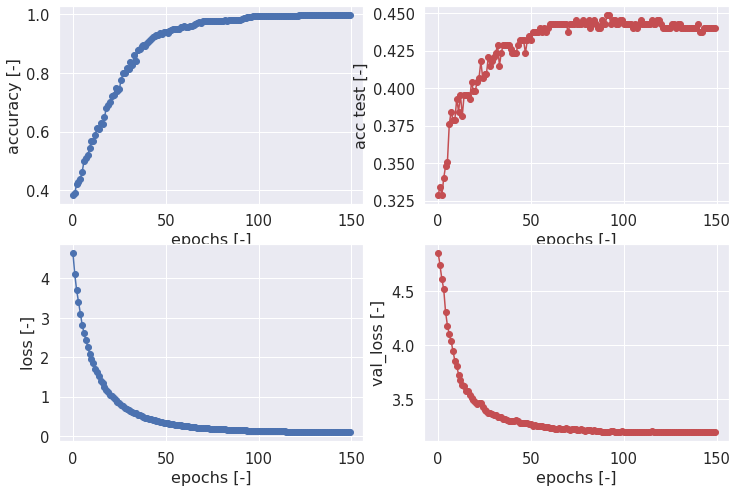

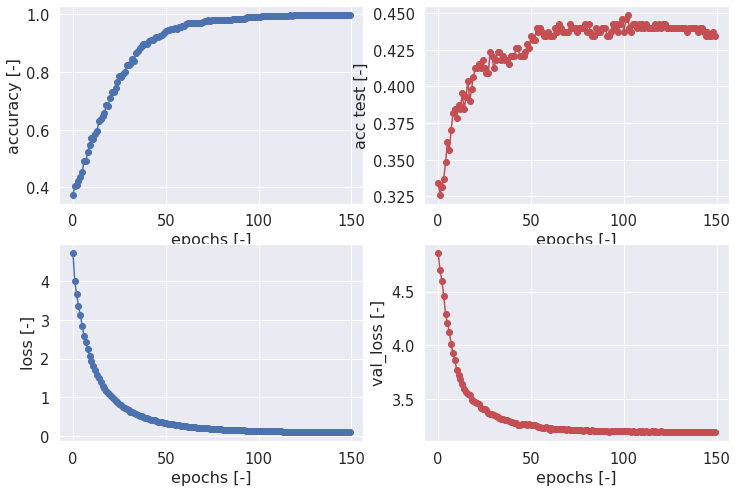

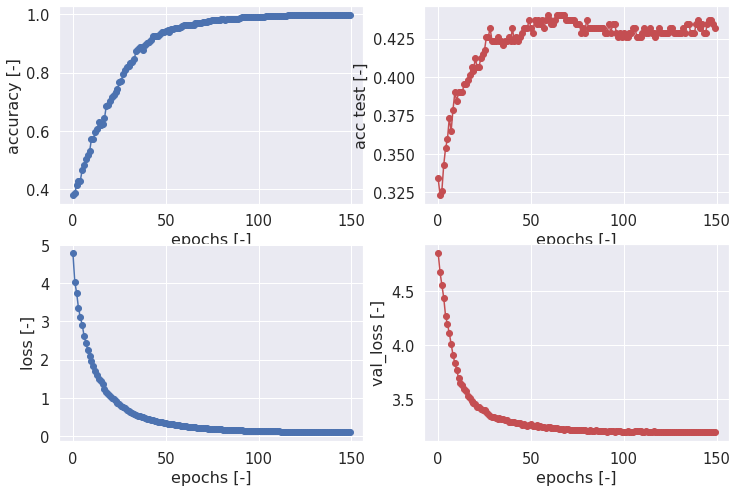

In [0]:
name_df_res = 'df_res_filters_gu0_50nod'

# initializers 
init_he_n = keras.initializers.he_normal(seed=0)
init_glorot_u = keras.initializers.glorot_uniform(seed=0)
# Hyper-parameters
lr = 3e-8
decay = 1e-6
momentum = 0.9
nesterov = True 
#nb_filters = 320 # Conv2D layers
nb_nodes = 50 # first FC layer
conv_init = init_glorot_u # Conv2D layers
dens_init = init_glorot_u # First FC Dense layer
out_init = init_glorot_u # Output FC Dense layer

# Fitting parameters
epochs = 150
batch_size = None
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                   verbose=1, patience=30,
                                   restore_best_weights=True)
# init output variables
df_res = None
#list_nb_filters = []
#list_nb_try = []

# loop on nb filter to check if accuracy is better and memory not saturated
for nb_filters in [64, 128, 256, 320]:
  print("nb_filters: ", nb_filters)
  for nb_try in range(0, 3):
    print("nb_try: ", nb_try)
    #list_nb_filters.append(nb_filters)
    #list_nb_try.append(nb_try)

    # Model creation
    my_VGG16_03 = Sequential()  # Création d'un réseau de neurones vide 
    my_VGG16_03.name = 'my_VGG16_03_{}filt_gu0_50nod_{}'.format(nb_filters, 
                                                               nb_try)

    # Ajout de la première couche de convolution, suivie d'une couche ReLU
    my_VGG16_03.add(Conv2D(nb_filters, kernel_size=3, strides=1, 
                          input_shape=(224, 224, 3),
                          padding='same', activation='relu',
                          kernel_initializer=conv_init))
    my_VGG16_03.add(MaxPooling2D(pool_size=(2,2), strides=(2,2))) # test
    # Ajout de la deuxième couche de convolution, suivie  d'une couche ReLU
    my_VGG16_03.add(Conv2D(nb_filters, kernel_size=3, strides=1, padding='same', 
                          activation='relu',
                          kernel_initializer=conv_init))

    # Ajout de la première couche de pooling
    my_VGG16_03.add(MaxPooling2D(pool_size=(2,2), strides=(2,2))) # test
    my_VGG16_03.add(Flatten())  # Conversion des matrices 3D en vecteur 1D

    # Ajout de la première couche fully-connected, suivie d'une couche ReLU
    my_VGG16_03.add(Dense(nb_nodes, activation='relu',
                      kernel_initializer=dens_init))

    # Ajout de la dernière couche fully-connected qui permet de classifier
    my_VGG16_03.add(Dense(nb_breeds, activation='softmax',
                    kernel_initializer=out_init))
    print(my_VGG16_03.summary())

    # optimizer
    sgd_2 = optimizers.SGD(lr=lr, decay=decay, momentum=momentum, 
                           nesterov=nesterov) 
    # compile model
    my_VGG16_03.compile(loss="categorical_crossentropy", optimizer=sgd_2, 
                    metrics=["accuracy"])

    t_fit_0 = time.time()
    # fitting
    model_info_3 = my_VGG16_03.fit(X_train, Y_train, epochs=epochs, 
                                batch_size=batch_size, verbose=2,
                                validation_data=(X_test, Y_test),
                                callbacks=[es])
    t_fit_1 = time.time()
    print("Timing: ", t_fit_1 - t_fit_0)

    # save : model info
    joblib.dump(model_info_3.history, 
                path_data + 'hist_' + my_VGG16_03.name + '.pkl'.\
                format(nb_filters, nb_try), compress=True)
    print("model_info_3 history Saved here:\n{}".\
          format(path_data + 'hist_' + my_VGG16_03.name + '.pkl'.\
                format(nb_filters, nb_try)))

    # plot results at each iterations
    plot_history(model_info_3.history)

    #  save
    my_VGG16_03.save(path_data + my_VGG16_03.name + '.h5')

    # predict as binary labels
    t_pred_0 = time.time()
    Y_train_pred = my_VGG16_03.predict(X_train)
    t_pred_1 = time.time()
    # predict as binary labels
    t_pred_2 = time.time()
    Y_test_pred = my_VGG16_03.predict(X_test)
    t_pred_3 = time.time()

    # prepare results
    series_scores = evaluate_mdl_scorings(Y_train, Y_train_pred, 
                                      Y_test, Y_test_pred, 
      timing_fit=t_fit_1 - t_fit_0, 
      timing_pred=t_pred_3-t_pred_2+t_pred_1-t_pred_0)
    df_res = add_score(df_res, series_scores, my_VGG16_03.name)
    df_res.at[my_VGG16_03.name,"nb_filters"] = nb_filters
    df_res.at[my_VGG16_03.name,"nb_try"] = nb_try
    # save results
    joblib.dump(df_res, path_data + name_df_res + '.pkl', compress=True)
    print(name_df_res + " Saved here:\n" + path_data + name_df_res + '.pkl')

# save results
joblib.dump(df_res, path_data + name_df_res + '.pkl', compress=True)
print(name_df_res + " Saved here:\n" + path_data + name_df_res + '.pkl')
    
exec(name_df_res+'=df_res.copy()')
exec(name_df_res)

In [0]:
df_res_filters_gu0_50nod

,acc_test,acc_train,nb_filters,nb_try,t_fit,t_pred
my_VGG16_03_64filt_gu0_50nod_0,0.387187,0.906667,64.0,0.0,278.967669,1.143587
my_VGG16_03_64filt_gu0_50nod_1,0.389972,0.903333,64.0,1.0,278.466687,1.169961
my_VGG16_03_64filt_gu0_50nod_2,0.376045,0.913333,64.0,2.0,278.685001,1.186586
my_VGG16_03_128filt_gu0_50nod_0,0.428969,0.976667,128.0,0.0,569.346708,2.179522
my_VGG16_03_128filt_gu0_50nod_1,0.420613,0.973333,128.0,1.0,506.795024,2.194590
my_VGG16_03_128filt_gu0_50nod_2,0.423398,0.960000,128.0,2.0,488.134610,2.228237
my_VGG16_03_256filt_gu0_50nod_0,0.440111,0.996667,256.0,0.0,1207.053412,4.388344
my_VGG16_03_256filt_gu0_50nod_1,0.434540,0.996667,256.0,1.0,1206.822917,4.349530
my_VGG16_03_256filt_gu0_50nod_2,0.431755,0.996667,256.0,2.0,1198.448970,4.437499


In [0]:
print("Loading from disk df_results...")
df_results = joblib.load(path_df_results)
print("Loading from disk df_res_filters...")
df_res_filters = joblib.load(path_data + 'df_res_filters.pkl')
print("Loading from disk df_res_nodes...")
df_res_nodes = joblib.load(path_data + 'df_res_nodes.pkl')
print("Loading from disk df_res_filters_max...")
df_res_filters_max = joblib.load(path_data + 'df_res_filters_max.pkl')
print("Loading from disk df_res_filters_he_50nod.pkl...")
df_res_filters_he_50nod = joblib.load(path_data + 'df_res_filters_he_50nod.pkl')
print("Loading from disk df_res_filters_gu0_50nod.pkl...")
df_res_filters_gu0_50nod = joblib.load(path_data + 'df_res_filters_gu0_50nod.pkl')


Loading from disk df_results...
Loading from disk df_res_filters...
Loading from disk df_res_nodes...
Loading from disk df_res_filters_max...
Loading from disk df_res_filters_he_50nod.pkl...
Loading from disk df_res_filters_gu0_50nod.pkl...


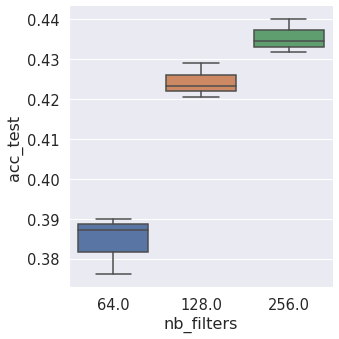

In [0]:
sns.catplot(x="nb_filters", y="acc_test", kind="box", 
            data=df_res_filters_gu0_50nod);

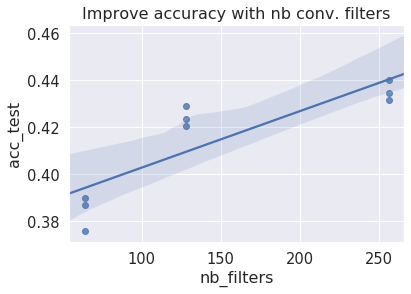

In [0]:
ax = sns.regplot(x="nb_filters", y="acc_test", data=df_res_filters_gu0_50nod);
ax.set_title("Improve accuracy with nb conv. filters");

Text(0.5, 1.0, 'Increase of time with number of conv. filters')

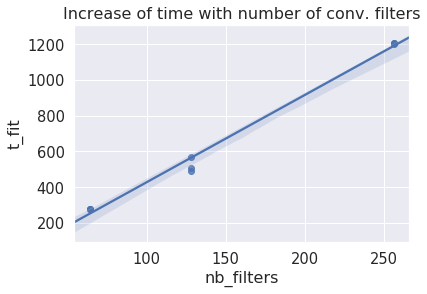

In [0]:
ax = sns.regplot(x="nb_filters", y="t_fit", data=df_res_filters_gu0_50nod);
ax.set_title("Increase of time with number of conv. filters")

In [0]:
nb_splits = df_res_filters_gu0_50nod["nb_try"].nunique()
def confid_interv(value):
  return 1.96*np.std(value)/np.sqrt(nb_splits)
df_filters = df_res_filters_gu0_50nod.pivot_table(values=["acc_test",	
                                                         "acc_train", 
                                                "t_fit",	"t_pred"],
                           index="nb_filters", aggfunc={np.mean, confid_interv})
df_filters

acc_test               acc_train                   t_fit  \
           confid_interv      mean confid_interv      mean confid_interv   
nb_filters                                                                 
64.0            0.006809  0.384401      0.004705  0.907778      0.232078   
128.0           0.003931  0.424327      0.008148  0.970000     39.302094   
256.0           0.003931  0.435469      0.000000  0.996667      4.529765   

                               t_pred            
                   mean confid_interv      mean  
nb_filters                                       
64.0         278.706452      0.020034  1.166711  
128.0        521.425447      0.023044  2.200783  
256.0       1204.108433      0.040733  4.391791

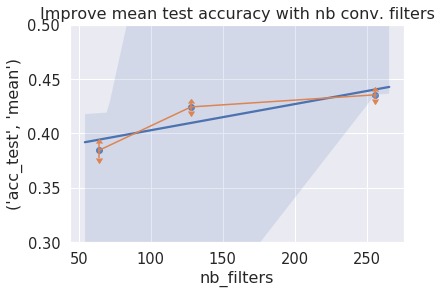

In [0]:
df_filters["nb_filters"] = df_filters.index
ax = sns.regplot(x=df_filters["nb_filters"] , y=df_filters[("acc_test","mean")]);
ax.set_title("Improve mean test accuracy with nb conv. filters");
ax.set_ylim([0.3,0.5])
plt.errorbar(df_filters["nb_filters"], df_filters[("acc_test","mean")], 
             yerr=df_filters[("acc_test","confid_interv")], uplims=True, 
             lolims=True);

### Loop overs runs / 256 filters / 50 nodes FC / initialization HE normal random  (10 runs)

Random again to look for better results


nb_try:  0
Model: "my_CNN_256filt_50nod_he_0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 224, 224, 256)     7168      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 112, 112, 256)     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 256)     590080    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 256)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 802816)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                40140850  
_________________________________________________________________
dense_4 (Dense)              (

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/150
 - 3s - loss: 11.0968 - acc: 0.2867 - val_loss: 10.2935 - val_acc: 0.3398
Epoch 2/150
 - 2s - loss: 10.9817 - acc: 0.3033 - val_loss: 10.5844 - val_acc: 0.2981
Epoch 3/150
 - 2s - loss: 10.4584 - acc: 0.3267 - val_loss: 10.1896 - val_acc: 0.3454
Epoch 4/150
 - 2s - loss: 9.8860 - acc: 0.3667 - val_loss: 10.1086 - val_acc: 0.3538
Epoch 5/150
 - 2s - loss: 9.8773 - acc: 0.3633 - val_loss: 9.7463 - val_acc: 0.3621
Epoch 6/150
 - 2s - loss: 9.4344 - acc: 0.3900 - val_loss: 9.7389 - val_acc: 0.3649
Epoch 7/150
 - 2s - loss: 9.2548 - acc: 0.4033 - val_loss: 10.0341 - val_acc: 0.3538
Epoch 8/150
 - 2s - loss: 8.9070 - acc: 0.4333 - val_loss: 9.9881 - val_acc: 0.3621
Epoch 9/150
 - 2s - loss: 8.7836 - acc: 0.4467 - val_loss: 10.1133 - val_acc: 0.3454
Epoch 10/150
 - 2s - loss: 8.6874 - acc: 0.4433 - val_loss: 10.0490 - val_acc: 0.3565
Epoch 11/150
 - 2s - loss: 8.6801 - acc: 0.4533 - val_loss: 10.3300 - val_acc: 0.3343
Epoch 12/150
 - 2

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/150
 - 3s - loss: 9.6221 - acc: 0.3800 - val_loss: 10.2995 - val_acc: 0.3426
Epoch 2/150
 - 2s - loss: 9.4134 - acc: 0.4033 - val_loss: 10.0677 - val_acc: 0.3565
Epoch 3/150
 - 2s - loss: 9.1057 - acc: 0.4333 - val_loss: 10.0204 - val_acc: 0.3565
Epoch 4/150
 - 2s - loss: 9.0847 - acc: 0.4333 - val_loss: 9.8627 - val_acc: 0.3788
Epoch 5/150
 - 2s - loss: 8.8815 - acc: 0.4400 - val_loss: 10.0909 - val_acc: 0.3538
Epoch 6/150
 - 2s - loss: 8.9007 - acc: 0.4033 - val_loss: 10.0392 - val_acc: 0.3510
Epoch 7/150
 - 2s - loss: 7.9856 - acc: 0.4700 - val_loss: 9.5786 - val_acc: 0.3788
Epoch 8/150
 - 2s - loss: 9.7316 - acc: 0.3600 - val_loss: 9.5234 - val_acc: 0.3844
Epoch 9/150
 - 2s - loss: 9.1446 - acc: 0.4067 - val_loss: 9.3860 - val_acc: 0.3844
Epoch 10/150
 - 2s - loss: 8.3245 - acc: 0.4567 - val_loss: 9.4471 - val_acc: 0.3983
Epoch 11/150
 - 2s - loss: 8.3689 - acc: 0.4600 - val_loss: 8.7944 - val_acc: 0.4262
Epoch 12/150
 - 2s - lo

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/150
 - 3s - loss: 9.7414 - acc: 0.3267 - val_loss: 10.3836 - val_acc: 0.3259
Epoch 2/150
 - 2s - loss: 8.9371 - acc: 0.4067 - val_loss: 10.2057 - val_acc: 0.3454
Epoch 3/150
 - 2s - loss: 8.6182 - acc: 0.4300 - val_loss: 9.9979 - val_acc: 0.3482
Epoch 4/150
 - 2s - loss: 8.1508 - acc: 0.4667 - val_loss: 10.5888 - val_acc: 0.3287
Epoch 5/150
 - 2s - loss: 8.2510 - acc: 0.4567 - val_loss: 10.1953 - val_acc: 0.3482
Epoch 6/150
 - 2s - loss: 8.3473 - acc: 0.4467 - val_loss: 10.2159 - val_acc: 0.3315
Epoch 7/150
 - 2s - loss: 7.9647 - acc: 0.4800 - val_loss: 9.9093 - val_acc: 0.3621
Epoch 8/150
 - 2s - loss: 7.5152 - acc: 0.5233 - val_loss: 9.7558 - val_acc: 0.3677
Epoch 9/150
 - 2s - loss: 7.3212 - acc: 0.5233 - val_loss: 9.8696 - val_acc: 0.3649
Epoch 10/150
 - 2s - loss: 7.4164 - acc: 0.5167 - val_loss: 9.7176 - val_acc: 0.3760
Epoch 11/150
 - 2s - loss: 7.1703 - acc: 0.5267 - val_loss: 9.3630 - val_acc: 0.3844
Epoch 12/150
 - 2s - lo

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/150
 - 3s - loss: 10.8556 - acc: 0.3133 - val_loss: 11.4830 - val_acc: 0.2869
Epoch 2/150
 - 2s - loss: 10.7808 - acc: 0.3300 - val_loss: 11.5835 - val_acc: 0.2813
Epoch 3/150
 - 2s - loss: 10.7991 - acc: 0.3300 - val_loss: 11.5721 - val_acc: 0.2813
Epoch 4/150
 - 2s - loss: 10.7991 - acc: 0.3300 - val_loss: 11.5386 - val_acc: 0.2841
Epoch 5/150
 - 2s - loss: 10.7519 - acc: 0.3300 - val_loss: 11.5386 - val_acc: 0.2841
Epoch 6/150
 - 2s - loss: 10.7454 - acc: 0.3333 - val_loss: 11.5386 - val_acc: 0.2841
Epoch 7/150
 - 2s - loss: 10.7454 - acc: 0.3333 - val_loss: 11.5386 - val_acc: 0.2841
Epoch 8/150
 - 2s - loss: 10.7454 - acc: 0.3333 - val_loss: 11.5386 - val_acc: 0.2841
Epoch 9/150
 - 2s - loss: 10.7454 - acc: 0.3333 - val_loss: 11.5386 - val_acc: 0.2841
Epoch 10/150
 - 2s - loss: 10.7454 - acc: 0.3333 - val_loss: 11.5386 - val_acc: 0.2841
Epoch 11/150
 - 2s - loss: 10.7454 - acc: 0.3333 - val_loss: 11.5386 - val_acc: 0.2841
Epoch 

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/150
 - 3s - loss: 9.5981 - acc: 0.3700 - val_loss: 10.3904 - val_acc: 0.3426
Epoch 2/150
 - 2s - loss: 9.5545 - acc: 0.3833 - val_loss: 10.7361 - val_acc: 0.3120
Epoch 3/150
 - 2s - loss: 9.9978 - acc: 0.3633 - val_loss: 10.8140 - val_acc: 0.3259
Epoch 4/150
 - 2s - loss: 10.0692 - acc: 0.3633 - val_loss: 11.0012 - val_acc: 0.3120
Epoch 5/150
 - 2s - loss: 9.8640 - acc: 0.3700 - val_loss: 10.9616 - val_acc: 0.3092
Epoch 6/150
 - 2s - loss: 9.5211 - acc: 0.4000 - val_loss: 10.8477 - val_acc: 0.3148
Epoch 7/150
 - 2s - loss: 9.5785 - acc: 0.3933 - val_loss: 10.7476 - val_acc: 0.3259
Epoch 8/150
 - 2s - loss: 9.0624 - acc: 0.4300 - val_loss: 10.5134 - val_acc: 0.3343
Epoch 9/150
 - 2s - loss: 8.7923 - acc: 0.4367 - val_loss: 10.3342 - val_acc: 0.3454
Epoch 10/150
 - 2s - loss: 8.7833 - acc: 0.4367 - val_loss: 10.3087 - val_acc: 0.3426
Epoch 11/150
 - 2s - loss: 8.4895 - acc: 0.4633 - val_loss: 10.3342 - val_acc: 0.3482
Epoch 12/150
 - 

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/150
 - 3s - loss: 10.2401 - acc: 0.3500 - val_loss: 11.2357 - val_acc: 0.2869
Epoch 2/150
 - 2s - loss: 10.0728 - acc: 0.3700 - val_loss: 10.9975 - val_acc: 0.2925
Epoch 3/150
 - 2s - loss: 10.0982 - acc: 0.3433 - val_loss: 10.8612 - val_acc: 0.3120
Epoch 4/150
 - 2s - loss: 10.1900 - acc: 0.3567 - val_loss: 10.3454 - val_acc: 0.3482
Epoch 5/150
 - 2s - loss: 10.4832 - acc: 0.3467 - val_loss: 10.4951 - val_acc: 0.3398
Epoch 6/150
 - 2s - loss: 10.6473 - acc: 0.3333 - val_loss: 10.2577 - val_acc: 0.3538
Epoch 7/150
 - 2s - loss: 10.3146 - acc: 0.3500 - val_loss: 10.3510 - val_acc: 0.3482
Epoch 8/150
 - 2s - loss: 10.0102 - acc: 0.3633 - val_loss: 10.2915 - val_acc: 0.3565
Epoch 9/150
 - 2s - loss: 9.9145 - acc: 0.3800 - val_loss: 10.3193 - val_acc: 0.3454
Epoch 10/150
 - 2s - loss: 9.8328 - acc: 0.3900 - val_loss: 10.2700 - val_acc: 0.3482
Epoch 11/150
 - 2s - loss: 9.8327 - acc: 0.3900 - val_loss: 10.2524 - val_acc: 0.3482
Epoch 12/

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/150
 - 3s - loss: 10.1911 - acc: 0.3533 - val_loss: 10.4891 - val_acc: 0.3343
Epoch 2/150
 - 2s - loss: 9.9153 - acc: 0.3533 - val_loss: 10.8516 - val_acc: 0.3036
Epoch 3/150
 - 2s - loss: 8.8753 - acc: 0.4300 - val_loss: 10.0333 - val_acc: 0.3482
Epoch 4/150
 - 2s - loss: 9.1848 - acc: 0.4000 - val_loss: 9.8080 - val_acc: 0.3760
Epoch 5/150
 - 2s - loss: 8.9511 - acc: 0.4367 - val_loss: 10.0567 - val_acc: 0.3482
Epoch 6/150
 - 2s - loss: 8.8855 - acc: 0.4267 - val_loss: 9.8004 - val_acc: 0.3705
Epoch 7/150
 - 2s - loss: 9.7835 - acc: 0.3800 - val_loss: 9.7538 - val_acc: 0.3900
Epoch 8/150
 - 2s - loss: 10.0541 - acc: 0.3667 - val_loss: 9.8033 - val_acc: 0.3816
Epoch 9/150
 - 2s - loss: 9.3314 - acc: 0.4033 - val_loss: 9.7957 - val_acc: 0.3705
Epoch 10/150
 - 2s - loss: 8.5447 - acc: 0.4400 - val_loss: 9.1146 - val_acc: 0.4178
Epoch 11/150
 - 2s - loss: 8.4650 - acc: 0.4533 - val_loss: 9.4560 - val_acc: 0.3844
Epoch 12/150
 - 2s - l

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Train on 300 samples, validate on 359 samples
Epoch 1/150
 - 3s - loss: 9.6075 - acc: 0.3833 - val_loss: 8.9938 - val_acc: 0.4067
Epoch 2/150
 - 2s - loss: 9.1967 - acc: 0.4100 - val_loss: 9.1296 - val_acc: 0.4150
Epoch 3/150
 - 2s - loss: 9.4860 - acc: 0.4000 - val_loss: 9.4095 - val_acc: 0.3955
Epoch 4/150
 - 2s - loss: 9.2410 - acc: 0.4133 - val_loss: 9.1065 - val_acc: 0.4039
Epoch 5/150
 - 2s - loss: 8.1489 - acc: 0.4767 - val_loss: 8.6905 - val_acc: 0.4262
Epoch 6/150
 - 2s - loss: 8.7489 - acc: 0.4400 - val_loss: 9.0655 - val_acc: 0.4123
Epoch 7/150
 - 2s - loss: 8.5218 - acc: 0.4600 - val_loss: 8.9217 - val_acc: 0.4206
Epoch 8/150
 - 2s - loss: 8.1471 - acc: 0.4633 - val_loss: 8.7331 - val_acc: 0.4234
Epoch 9/150
 - 2s - loss: 7.6102 - acc: 0.5133 - val_loss: 8.9560 - val_acc: 0.4123
Epoch 10/150
 - 2s - loss: 7.3872 - acc: 0.5300 - val_loss: 8.5420 - val_acc: 0.4345
Epoch 11/150
 - 2s - loss: 7.4116 - acc: 0.5300 - val_loss: 8.7703 - val_acc: 0.4178
Epoch 12/150
 - 2s - loss: 7

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


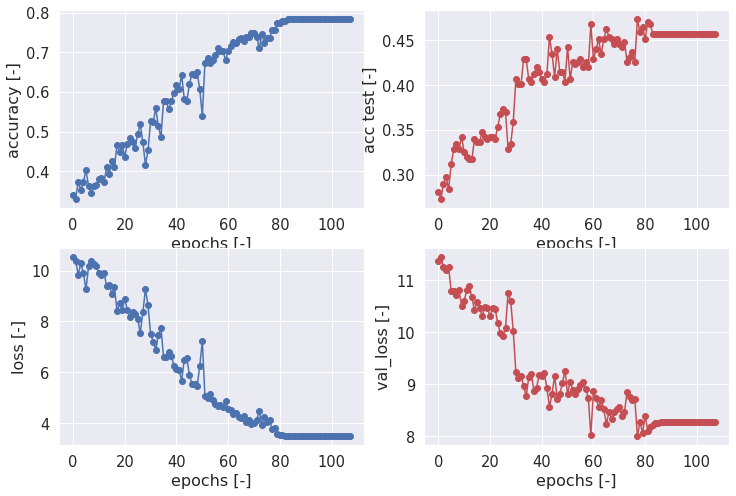

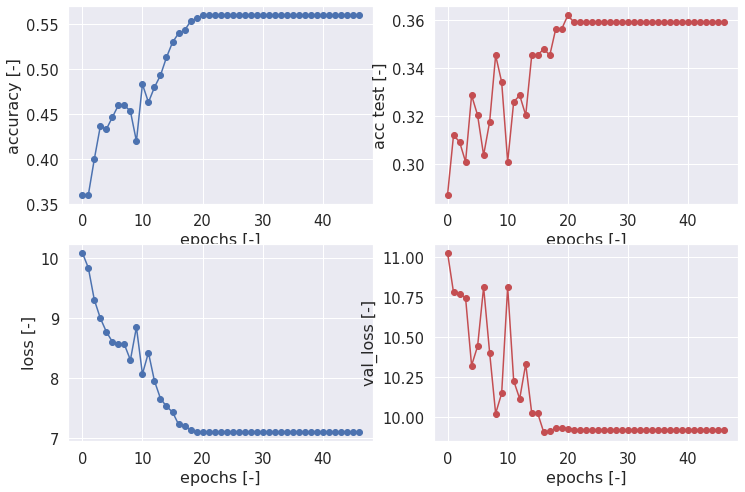

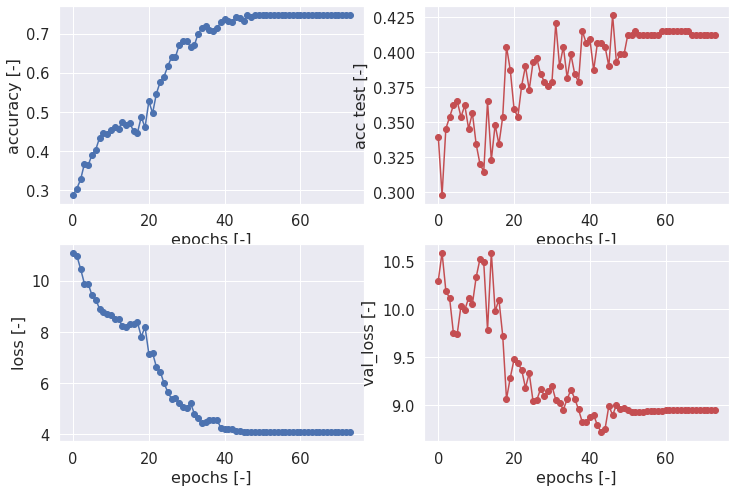

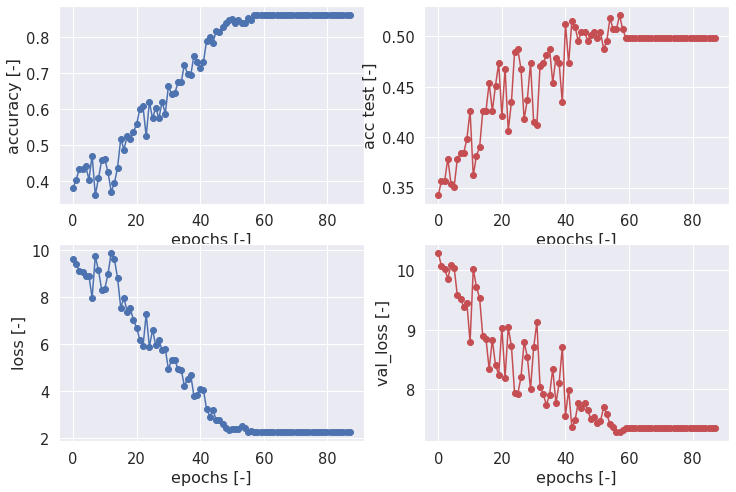

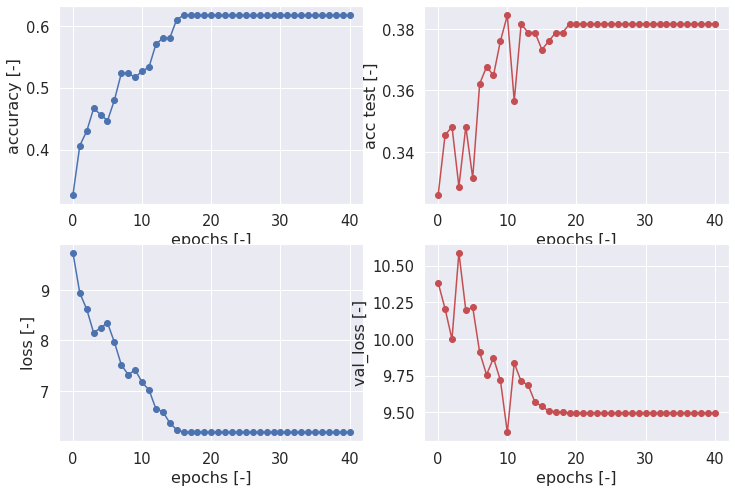

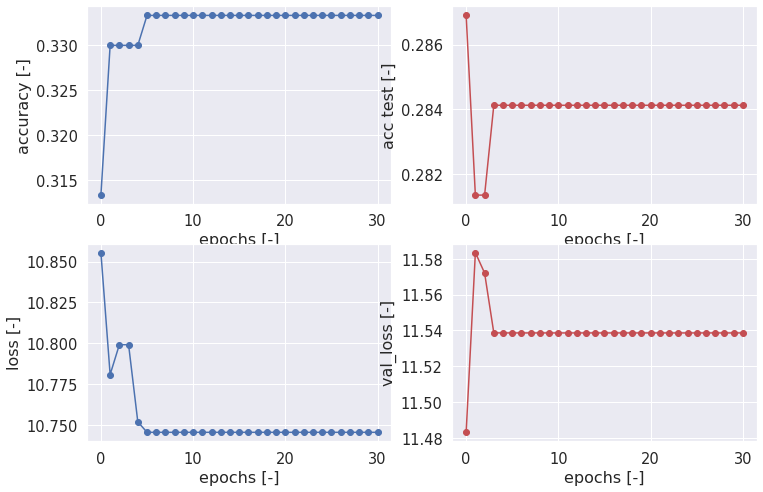

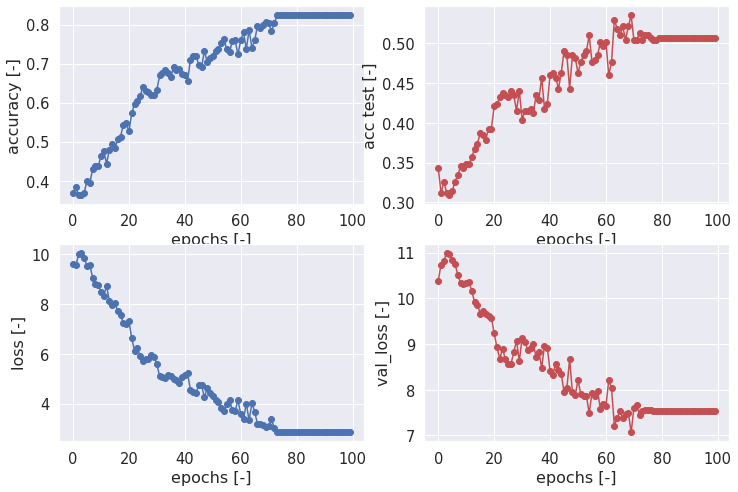

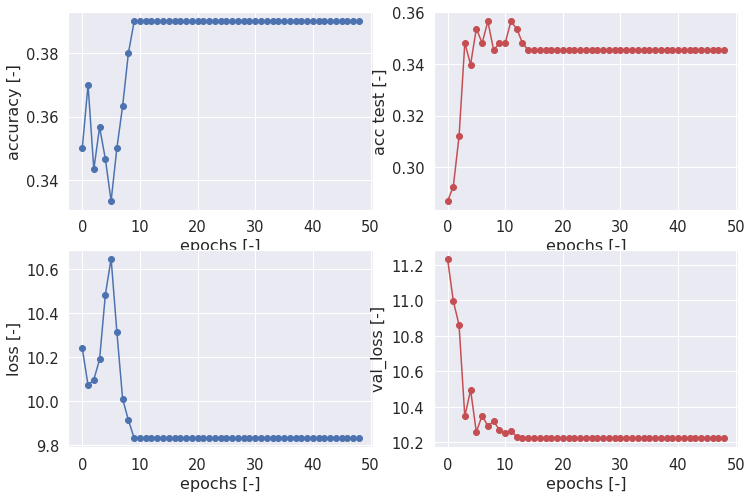

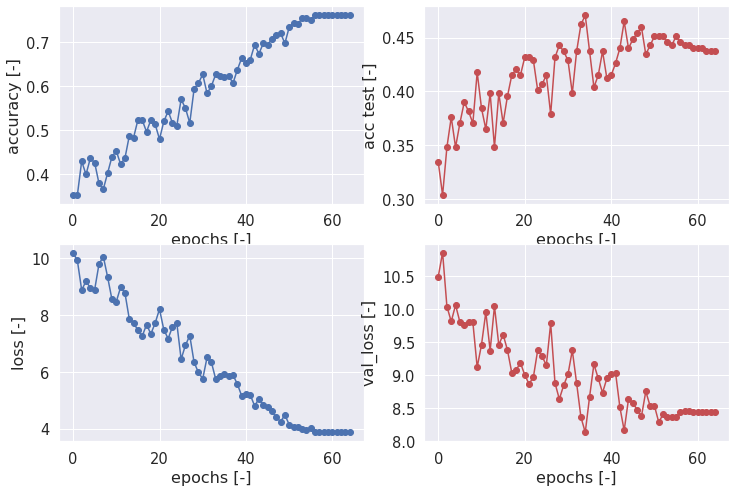

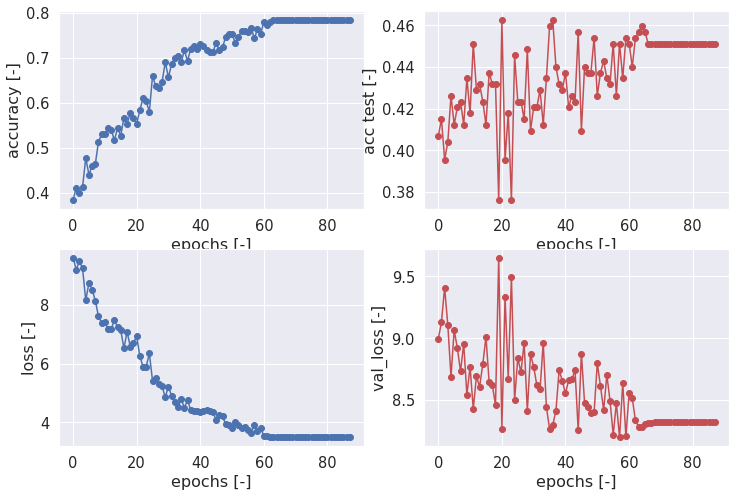

In [0]:
name_df_res = 'df_res_256filt_50nod_he'

# initializers 
init_he_n = keras.initializers.he_normal(seed=None)
init_glorot_u = keras.initializers.glorot_uniform(seed=None)

# model parameters
nb_filters = 256 # fixed nb filters
nb_nodes = 50 # first FC layer
conv_init = init_he_n # Conv2D layers
dens_init = init_he_n # First FC Dense layer
out_init = init_glorot_u # Output FC Dense layer


# Hyper-parameters
lr = 3e-8
decay = 1e-6
momentum = 0.9
nesterov = True 

# Fitting parameters
epochs = 150
batch_size = None
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                   verbose=1, patience=30,
                                   restore_best_weights=True)
# init output variables
df_res = None

for nb_try in range(0, 10):
  print("nb_try: ", nb_try)

  # Model creation
  my_VGG16_03 = Sequential()  # Création d'un réseau de neurones vide 
 
  my_VGG16_03.name = 'my_CNN_{}filt_{}nod_he_{}'.format(nb_filters, nb_nodes,
                                                              nb_try)

  # Ajout de la première couche de convolution, suivie d'une couche ReLU
  my_VGG16_03.add(Conv2D(nb_filters, kernel_size=3, strides=1, 
                        input_shape=(224, 224, 3),
                        padding='same', activation='relu',
                        kernel_initializer=conv_init))
  my_VGG16_03.add(MaxPooling2D(pool_size=(2,2), strides=(2,2))) # test
  # Ajout de la deuxième couche de convolution, suivie  d'une couche ReLU
  my_VGG16_03.add(Conv2D(nb_filters, kernel_size=3, strides=1, padding='same', 
                        activation='relu',
                        kernel_initializer=conv_init))

  # Ajout de la première couche de pooling
  my_VGG16_03.add(MaxPooling2D(pool_size=(2,2), strides=(2,2))) # test
  my_VGG16_03.add(Flatten())  # Conversion des matrices 3D en vecteur 1D

  # Ajout de la première couche fully-connected, suivie d'une couche ReLU
  my_VGG16_03.add(Dense(nb_nodes, activation='relu',
                    kernel_initializer=dens_init))

  # Ajout de la dernière couche fully-connected qui permet de classifier
  my_VGG16_03.add(Dense(nb_breeds, activation='softmax',
                  kernel_initializer=out_init))
  print(my_VGG16_03.summary())

  # optimizer
  sgd_2 = optimizers.SGD(lr=lr, decay=decay, momentum=momentum, 
                          nesterov=nesterov) 
  # compile model
  my_VGG16_03.compile(loss="categorical_crossentropy", optimizer=sgd_2, 
                  metrics=["accuracy"])

  t_fit_0 = time.time()
  # fitting
  model_info_3 = my_VGG16_03.fit(X_train, Y_train, epochs=epochs, 
                              batch_size=batch_size, verbose=2,
                              validation_data=(X_test, Y_test),
                              callbacks=[es])
  t_fit_1 = time.time()
  print("Timing: ", t_fit_1 - t_fit_0)

  # save : model info
  joblib.dump(model_info_3.history, 
              path_data + 'hist_' + my_VGG16_03.name + '.pkl'.\
              format(nb_filters, nb_try), compress=True)
  print("model_info_3 history Saved here:\n{}".\
        format(path_data + 'hist_' + my_VGG16_03.name + '.pkl'.\
              format(nb_filters, nb_try)))

  # plot results at each iterations
  plot_history(model_info_3.history)

  #  save model
  my_VGG16_03.save(path_data + my_VGG16_03.name + '.h5')

  # predict as binary labels
  t_pred_0 = time.time()
  Y_train_pred = my_VGG16_03.predict(X_train)
  t_pred_1 = time.time()
  # predict as binary labels
  t_pred_2 = time.time()
  Y_test_pred = my_VGG16_03.predict(X_test)
  t_pred_3 = time.time()

  # prepare results
  series_scores = evaluate_mdl_scorings(Y_train, Y_train_pred, 
                                    Y_test, Y_test_pred, 
    timing_fit=t_fit_1 - t_fit_0, 
    timing_pred=t_pred_3-t_pred_2+t_pred_1-t_pred_0)
  df_res = add_score(df_res, series_scores, my_VGG16_03.name)
  df_res.at[my_VGG16_03.name,"nb_filters"] = nb_filters
  df_res.at[my_VGG16_03.name,"nb_try"] = nb_try
  # save results
  joblib.dump(df_res, path_data + name_df_res + '.pkl', compress=True)
  print(name_df_res + " Saved here:\n" + path_data + name_df_res + '.pkl')

# save results
joblib.dump(df_res, path_data + name_df_res + '.pkl', compress=True)
print(name_df_res + " Saved here:\n" + path_data + name_df_res + '.pkl')
    
exec(name_df_res+'=df_res.copy()')
exec(name_df_res)

In [0]:
print("Loading from disk df_res_256filt_50nod_he...")
df_res_256filt_50nod_he = joblib.load(path_data + 'df_res_256filt_50nod_he.pkl')

Loading from disk df_res_256filt_50nod_he...


In [0]:
df_res_256filt_50nod_he

,acc_test,acc_test_3B_0,acc_test_3B_1,acc_test_3B_2,acc_train,nb_filters,nb_try,t_fit,t_pred
my_CNN_256filt_50nod_he_0,0.473538,0.618644,0.395683,0.411765,0.763333,256.0,0.0,238.723505,1.265160
my_CNN_256filt_50nod_he_1,0.348189,0.000000,0.496403,0.549020,0.540000,256.0,1.0,103.331855,1.273668
my_CNN_256filt_50nod_he_2,0.406685,0.372881,0.467626,0.362745,0.740000,256.0,2.0,162.179687,1.305196
my_CNN_256filt_50nod_he_3,0.520891,0.567797,0.539568,0.441176,0.860000,256.0,3.0,192.780873,1.300618
my_CNN_256filt_50nod_he_4,0.384401,0.593220,0.158273,0.450980,0.516667,256.0,4.0,90.801926,1.322351
my_CNN_256filt_50nod_he_5,0.286908,0.000000,0.050360,0.941176,0.330000,256.0,5.0,68.884036,1.389431
my_CNN_256filt_50nod_he_6,0.534819,0.584746,0.539568,0.470588,0.800000,256.0,6.0,223.203674,1.394404
my_CNN_256filt_50nod_he_7,0.345404,0.822034,0.007194,0.254902,0.390000,256.0,7.0,110.196935,1.421548
my_CNN_256filt_50nod_he_8,0.470752,0.423729,0.726619,0.176471,0.620000,256.0,8.0,145.456535,1.419582
my_CNN_256filt_50nod_he_9,0.451253,0.457627,0.633094,0.196078,0.760000,256.0,9.0,196.309972,1.435320


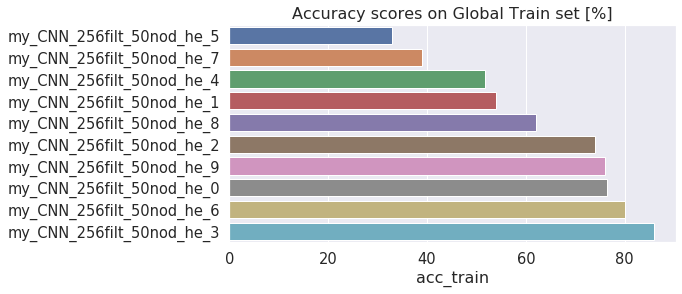

In [0]:
fig = plt.figure(figsize=(8, 4))
plt.title("Accuracy scores on Global Train set [%]")
ax = sns.barplot(
    y=df_res_256filt_50nod_he.sort_values(by="acc_train").index,
    x=100*df_res_256filt_50nod_he.sort_values(by="acc_train")["acc_train"], 
    orient="h")

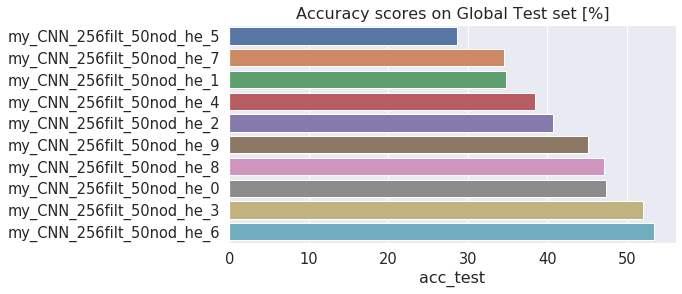

In [0]:
fig = plt.figure(figsize=(8, 4))
plt.title("Accuracy scores on Global Test set [%]")
ax = sns.barplot(
    y=df_res_256filt_50nod_he.sort_values(by="acc_test").index,
    x=100*df_res_256filt_50nod_he.sort_values(by="acc_test")["acc_test"], 
    orient="h")

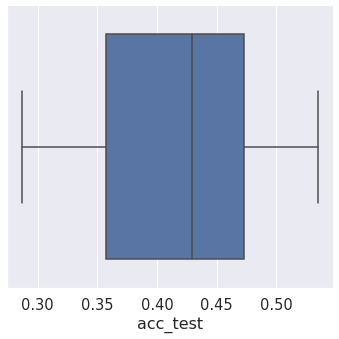

In [0]:
sns.catplot(x="acc_test", kind="box", 
            data=df_res_256filt_50nod_he);

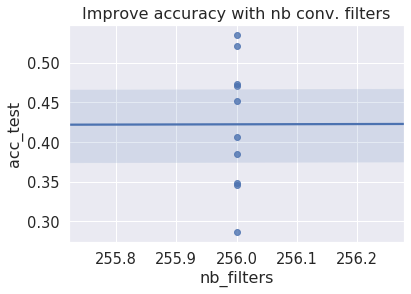

In [0]:
ax = sns.regplot(x="nb_filters", y="acc_test", data=df_res_256filt_50nod_he);
ax.set_title("Improve accuracy with nb conv. filters");

Text(0.5, 1.0, 'Increase of time with number of conv. filters')

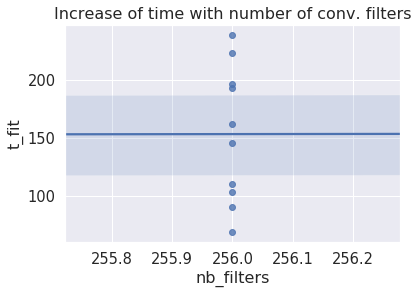

In [0]:
ax = sns.regplot(x="nb_filters", y="t_fit", data=df_res_256filt_50nod_he);
ax.set_title("Increase of time with number of conv. filters")

In [0]:
nb_splits = df_res_256filt_50nod_he["nb_try"].nunique()
def confid_interv(value):
  return 1.96*np.std(value)/np.sqrt(nb_splits)
df_tries = df_res_256filt_50nod_he.pivot_table(values=["acc_test",	
                                                         "acc_train", 
                                                "t_fit",	"t_pred"],
                           index="nb_filters", aggfunc={np.mean, confid_interv})
df_tries

acc_test               acc_train                t_fit  \
           confid_interv      mean confid_interv   mean confid_interv   
nb_filters                                                              
256.0           0.047853  0.422284      0.106848  0.632     34.575695   

                            t_pred            
                mean confid_interv      mean  
nb_filters                                    
256.0       153.1869      0.038671  1.352728

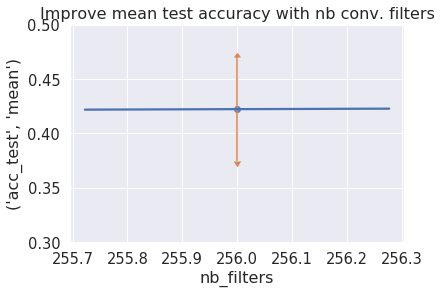

In [0]:
df_tries["nb_filters"] = df_tries.index
ax = sns.regplot(x=df_tries["nb_filters"] , y=df_tries[("acc_test","mean")]);
ax.set_title("Improve mean test accuracy with nb conv. filters");
ax.set_ylim([0.3,0.5])
plt.errorbar(df_tries["nb_filters"], df_tries[("acc_test","mean")], 
             yerr=df_tries[("acc_test","confid_interv")], uplims=True, 
             lolims=True);

#### Conclusion

Best model my_CNN_256filt_50nod_he_6 have acc test score of 53.5%



#### Compare

In [0]:
print("Loading from disk df_res_256filt_50nod_he...")
df_res_256filt_50nod_he = joblib.load(path_data + 'df_res_256filt_50nod_he.pkl')

Loading from disk df_res_256filt_50nod_he...


In [0]:
print("Loading from disk df_results...")
df_results = joblib.load(path_df_results)

Loading from disk df_results...


In [0]:
df_results = df_results.append(
    df_res_256filt_50nod_he.loc["my_CNN_256filt_50nod_he_6"])

In [0]:
# save results
joblib.dump(df_results, path_df_results, compress=True)
print(" df_results Saved here:\n" + path_df_results)

 df_results Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_results.pkl


In [0]:
df_res = df_results.filter(items=['vgg16', 'VGG16_TL_class_01', 'resnet50', 
                         "ResNet50_TL_class_01",
                         'my_CNN_256filt_50nod_he_6'], axis=0)
df_res

,acc_test,acc_test_10B_0,acc_test_10B_1,acc_test_10B_2,acc_test_10B_3,acc_test_10B_4,acc_test_10B_5,acc_test_10B_6,acc_test_10B_7,acc_test_10B_8,acc_test_10B_9,acc_test_3B_0,acc_test_3B_1,acc_test_3B_2,acc_train,t_fit,t_pred,nb_filters,nb_try
vgg16,0.885794,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.940678,0.863309,0.852941,0.883333,0.000000,6.288219,NaN,NaN
VGG16_TL_class_01,0.986072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.971223,0.990196,0.983333,36.452183,1.886233,NaN,NaN
resnet50,0.930362,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.949153,0.920863,0.921569,0.923333,0.000000,1.548604,NaN,NaN
ResNet50_TL_class_01,0.986072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.964029,1.000000,0.996667,31.100259,3.201744,NaN,NaN
my_CNN_256filt_50nod_he_6,0.534819,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.584746,0.539568,0.470588,0.800000,223.203674,1.394404,256.0,6.0


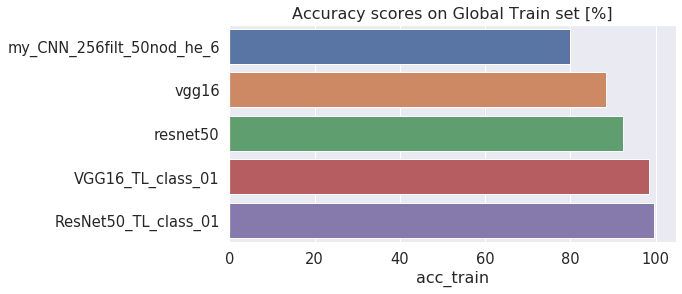

In [0]:
fig = plt.figure(figsize=(8, 4))
plt.title("Accuracy scores on Global Train set [%]")
ax = sns.barplot(
    y=df_res.sort_values(by="acc_train").index,
    x=100*df_res.sort_values(by="acc_train")["acc_train"], orient="h")

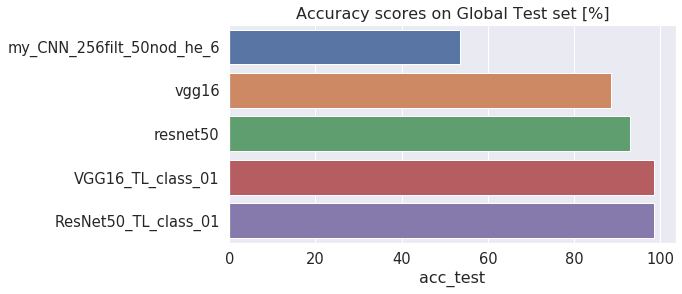

In [0]:
fig = plt.figure(figsize=(8, 4))
plt.title("Accuracy scores on Global Test set [%]")
ax = sns.barplot(
    y=df_res.sort_values(by="acc_test").index,
    x=100*df_res.sort_values(by="acc_test")["acc_test"], orient="h")

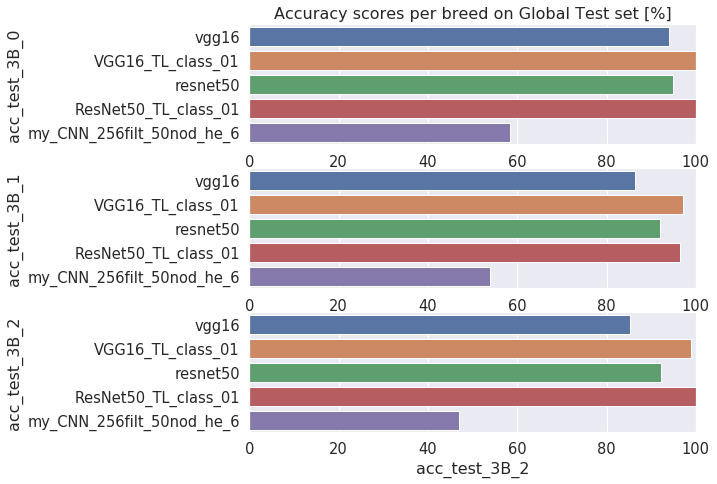

In [0]:
# plot Accuracy scores per breed on Global Test set

fig, arr_ax = plt.subplots(nb_breeds,1)
fig.set_size_inches([8, nb_breeds*25/10])
arr_ax[0].set_title("Accuracy scores per breed on Global Test set [%]")
for id in range(0,nb_breeds):
  label_curr = "acc_test_{}B_{}".format(nb_breeds, id)
  sns.barplot(ax=arr_ax[id], y=df_res.index,
      x=100*df_res[label_curr], orient="h")
  arr_ax[id].set_ylabel(label_curr)
  arr_ax[id].set_xlim([0,100])
  
 


#### Confusion matrix

In [0]:
# load best model
best_model_name = "my_CNN_256filt_50nod_he_6"
my_model = load_model(path_data + best_model_name + '.h5')
my_model.name 













Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




'my_CNN_256filt_50nod_he_6'

In [0]:
list_Y_classes

['Bernese_mountain_dog', 'Afghan_hound', 'Airedale']

In [0]:
Y_test_pred = my_model.predict(X_test)

In [0]:
Y_test_pred_num = np.argmax(Y_test_pred, axis=1)
Y_test_num = np.argmax(Y_test, axis=1)
# Confusion Matrix and Classification Report
target_names = np.array(list_Y_classes)
target_names = target_names[np.unique(np.array(np.concatenate((
    Y_test_pred_num, Y_test_num))))]
print(classification_report(Y_test_num, Y_test_pred_num, 
                            target_names=target_names))

np.set_printoptions(precision=2)

                      precision    recall  f1-score   support

Bernese_mountain_dog       0.57      0.58      0.58       118
        Afghan_hound       0.56      0.54      0.55       139
            Airedale       0.45      0.47      0.46       102

            accuracy                           0.53       359
           macro avg       0.53      0.53      0.53       359
        weighted avg       0.54      0.53      0.54       359



Confusion matrix, without normalization
[[69 24 25]
 [31 75 33]
 [20 34 48]]


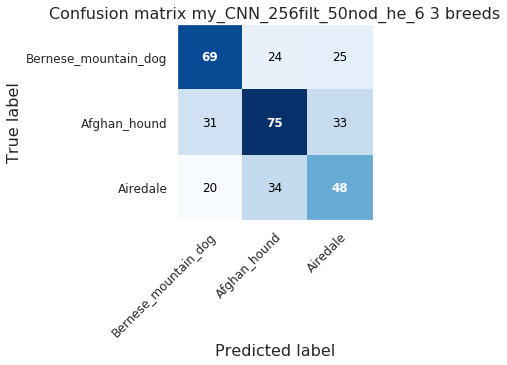

In [0]:
# Plot non-normalized confusion matrix
ax = plot_confusion_matrix(Y_test_num, Y_test_pred_num, classes=target_names,
  title='Confusion matrix {} 3 breeds'.format(my_model.name), size=8,
   fontsize=12)
#ax.set_ylim([nb_breeds-0.5,-0.5]);

Normalized confusion matrix
[[0.58 0.2  0.21]
 [0.22 0.54 0.24]
 [0.2  0.33 0.47]]


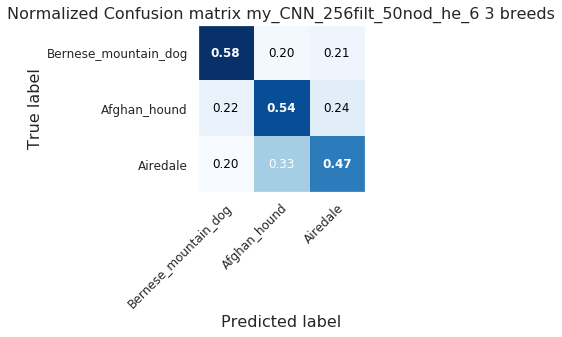

In [0]:
# Plot non-normalized confusion matrix
ax = plot_confusion_matrix(Y_test_num, Y_test_pred_num, classes=target_names,
                           normalize=True,
  title='Normalized Confusion matrix {} 3 breeds'.format(my_model.name), size=8,
   fontsize=12)
#ax.set_ylim([nb_breeds-0.5,-0.5]);

In [0]:
cm = confusion_matrix(Y_test_num, Y_test_pred_num)
cm.sum(axis=1)[:, np.newaxis]

array([[118],
       [139],
       [102]])

In [0]:
cm/cm.sum(axis=1)[:, np.newaxis]

array([[0.58, 0.2 , 0.21],
       [0.22, 0.54, 0.24],
       [0.2 , 0.33, 0.47]])

In [0]:
0.2+0.33+0.47

1.0